In [1]:
import os
import random
import sys
from contextlib import contextmanager
from functools import partial

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm

from core.api_queries import (
    Entsoe,
    OpenMeteo,
    get_city_geocoding,
)
from core.controller import EconomicMPC, GreenHouseModel, GreenhouseSimulator
from core.generator import (
    gen_step,
)
from core.greenhouse_model import GreenHouse, x_init, x_init_dict
from core.plot import plot_response, plot_states, set_size
from core.simulate import simulate

load_dotenv()


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


# For reproducibility
random.seed(40)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Times New Roman",
        "font.serif": "Times New Roman",
        "axes.grid": True,
    }
)

pd.options.plotting.backend = "plotly"

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

2025-06-27 13:58:51.188 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.189 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.189 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.190 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.190 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.191 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.191 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:51.192 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
/Users/m

In [2]:
dt = 60  # seconds

gh_model = GreenHouse(dt=dt)

cultivated_area = gh_model.A_c
lettuce_price = 0.0054  # EUR/g
N = 30  # number of control intervals

In [3]:
# Paths
filepath = "examples/"
start_date = pd.Timestamp.now()
# start_date = pd.Timestamp.now()
end_date = start_date + pd.Timedelta(days=2)
date_tag = f"{start_date.strftime('%Y-%m-%d')}_{(start_date + pd.Timedelta(days=15)).strftime('%Y-%m-%d')}-{dt}s"

In [4]:
x0 = x_init.copy()

u_min = [0.0] * len(gh_model.active_actuators)
u_max = [100.0] * len(gh_model.active_actuators)

y_legend = ["Structural", "Non-Structural"]
u_legend = [*gh_model.active_actuators.keys()]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

ylabel = "Dry Weight (g/m$^2$)"
xlabel = "Time"
ulabel = "Actuation (\\%)"

# Get Weather Data

In [5]:
filename = f"{filepath}data/weather-{date_tag}.csv"

if os.path.exists(filename):
    climate = pd.read_csv(filename, index_col=0, parse_dates=True)
else:
    openmeteo = OpenMeteo(
        latitude=52.52,  # Latitude of the location in degrees
        longitude=13.41,  # Longitude of the location in degrees
        altitude=157,
        tilt=[
            90,
            90,
            90,
            90,
            40,
            40,
        ],  # Tilt angle of the surface in degrees
        azimuth=[
            "NE",
            "SE",
            "SW",
            "NW",
            "SW",
            "NW",
        ],  # Azimuth angle of the surface in degrees (South facing)
        frequency="minutely_15",  # Frequency of the data
    )

    (
        city,
        country,
        country_code,
        tz,
        latitude,
        longitude,
        altitude,
    ) = get_city_geocoding("Bratislava")
    climate = (
        openmeteo.get_weather_data(
            start_date=start_date,
            end_date=end_date,
        )
        .tz_localize(tz, ambiguous=True)
        .asfreq(f"{dt}s")
        .interpolate(method="time")
    )
    entsoe = Entsoe()
    energy_cost = entsoe.get_electricity_price(
        country_code=country_code,
        start_date=start_date.tz_localize(tz),
        end_date=end_date.tz_localize(tz),
        tz=tz,
    )
    energy_cost = pd.concat([pd.Series(index=climate.index), energy_cost])
    energy_cost = energy_cost[~energy_cost.index.duplicated(keep="first")]
    climate["Electricity price [EUR/kWh]"] = (
        energy_cost.sort_index()
        .interpolate(method="time", limit_direction="both")
        .ffill()
        .bfill()
    )
    # climate.to_csv(filename)

2025-06-27 13:58:52.302 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-27 13:58:52.304 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 13:58:52.335 
  command:

    streamlit run /Users/mw/pyprojects/ecompc-greenhouse-platform/.venv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-27 13:58:52.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 13:58:52.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 13:58:52.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 13:58:52.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-2

In [6]:
# Plotting the DataFrame
climate.plot()

## Explore responses to steps in individual inputs

  3%|▎         | 44/1440 [00:00<00:02, 513.87it/s]


KeyboardInterrupt: 

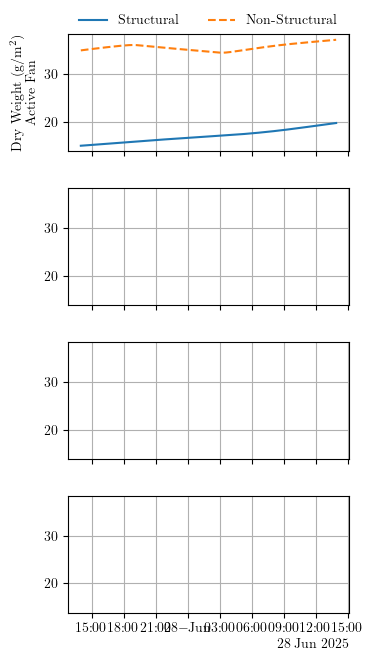

In [7]:
# [donotremove]
with_states = False

ncols = len(u_max)
fig, axs = plt.subplots(
    nrows=ncols,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=set_size(width="ieee", subplots=(ncols - 1, 1)),
)
if axs.ndim == 1:
    axs = axs.reshape(1, -1)
_gh_model = GreenHouse(dt=dt, return_format="array")

greenhouse_model = partial(_gh_model.model, climate=climate.values)
_greenhouse_model = partial(_gh_model._model, climate=climate.values)

sim_time_ = 86400 // dt
timestamps = pd.date_range(
    start=start_date, periods=sim_time_, freq=pd.Timedelta(seconds=dt)
)

for u_idx in range(ncols):
    u_min_ = u_min.copy()
    u_max_ = u_min.copy()
    if len(u_max) > u_idx:
        u_max_[u_idx] = u_max[u_idx]
    if len(u_max) < u_idx:
        u_min_ = u_max.copy()
        u_max_ = u_max.copy()
    u = partial(gen_step, u_min=u_min_, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model,
        u=u,  # type: ignore
        sim_time=sim_time_,
        t_s=dt,
        x0=x0,  # type: ignore
    )
    plot_response(
        timestamps,
        y_out[:, -2:],
        u_out,
        axs_=axs[0:1, u_idx],
        y_legend=y_legend if u_idx == 0 else None,
        u_legend=u_legend if u_idx == 0 else None,
    )

    if axs.shape[0] == 1:
        axs[0, u_idx].set_ylabel(f"{ylabel}\nActive {u_legend[u_idx]}")

    if with_states:
        xs = []
        for i, (x, u) in enumerate(zip(y_out, u_out)):
            _, x_ = _greenhouse_model(i * dt, tuple(x), tuple(u))
            xs.append(x_)
        df = pd.DataFrame(xs, index=timestamps).select_dtypes(
            include=["float"]
        )

        if u_idx == 0:
            # Plot response
            fig_states, axs_states = plt.subplots(
                nrows=len(df.columns),
                ncols=ncols,
                figsize=set_size(
                    width="ieee_full", subplots=(len(df.columns), ncols)
                ),
                sharex=True,
                sharey="row",
            )

        plot_states(df, axs_states[:, u_idx], set_ylabel=(u_idx == 0))

if axs.shape[0] > 1:
    axs[0, 0].set_ylabel(ylabel.replace(" (", "\n("))
    axs[1, 0].set_xlabel(xlabel)
    axs[1, 0].set_ylabel(ulabel.replace(" (", "\n("))

xformatter = mdates.DateFormatter("%H:%M")

for ax in axs[-1, :]:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.tick_params(axis="x", rotation=20)
    ax.xaxis.set_major_formatter(xformatter)

if with_states:
    for ax in axs_states[-1, :]:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.tick_params(axis="x", rotation=20)
        ax.xaxis.set_major_formatter(xformatter)


if axs.shape[0] > 1:
    lines_labels = [ax.get_legend_handles_labels() for ax in axs[0, :]]
    lines, labels = (sum(lol, []) for lol in zip(*lines_labels))
    fig.legend(
        lines,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=len(y_legend),
    )
    lines_labels = [ax.get_legend_handles_labels() for ax in axs[1, :]]
    lines, labels = (sum(lol, []) for lol in zip(*lines_labels))
    fig.legend(lines, labels, loc="lower center", ncol=len(u_legend))

fig.align_labels(axs[:, 0])
fig.tight_layout(pad=0.1)
fig.savefig(f"{filepath}results/step_response-outputs-{date_tag}.pdf")

if with_states:
    fig_states.align_ylabels(axs_states[:, 0])
    fig_states.tight_layout()
    fig_states.savefig(
        f"{filepath}results/step_response-states-{date_tag}.pdf"
    )

In [8]:
# === Model ===================================================================
# Create a model instance
model = GreenHouseModel(gh_model, climate_vars=climate.columns)

# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
# x0 = model.init_states(x0, u0, tvp0)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)


u0 = np.array(u0, ndmin=2).T
simulator.x0 = x0
simulator.set_initial_guess()

# Run the simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    # with suppress_stdout():
    U.iloc[step] = u0[:, 0]
    x0 = simulator.make_step(u0)
    if np.isnan(x0).any():
        raise ValueError("x0 contains NaN values.")
    X.iloc[step] = x0[:, 0]

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

100%|██████████| 2881/2881 [00:01<00:00, 2491.60it/s]


In [9]:
profit_costs = model.analyze_profit_and_costs(
    x0[:, 0] - x_init,
    U,
    climate["Electricity price [EUR/kWh]"].values[:sim_steps],
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-u_{int(u0[0][0])}-N_{N}-steps_{sim_steps}.csv"
)

In [10]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total']:.2f} EUR! 🤑"
)

Congrats, your greenhouse generated profit of 144.66 EUR! 🤑


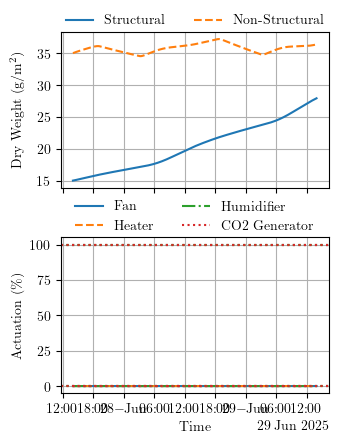

In [11]:
# [donotremove]
axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label=ylabel,
    u_label=ulabel,
    t_label=xlabel,
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/gh_sim-u_{int(u0[0][0])}-N_{N}-steps_{sim_steps}.pdf"
)

# Control Scenario

In [19]:
mpc.solver_stats

{'iter_count': 0,
 'n_call_callback_fun': 0,
 'n_call_nlp_f': 0,
 'n_call_nlp_g': 1,
 'n_call_nlp_grad': 0,
 'n_call_nlp_grad_f': 1,
 'n_call_nlp_jac_g': 0,
 'n_call_total': 1,
 'return_status': 'Invalid_Number_Detected',
 'success': False,
 't_proc_callback_fun': 0.0,
 't_proc_nlp_f': 0.0,
 't_proc_nlp_g': 7.7e-05,
 't_proc_nlp_grad': 0.0,
 't_proc_nlp_grad_f': 0.000159,
 't_proc_nlp_jac_g': 0.0,
 't_proc_total': 0.000913,
 't_wall_callback_fun': 0.0,
 't_wall_nlp_f': 0.0,
 't_wall_nlp_g': 7.6208e-05,
 't_wall_nlp_grad': 0.0,
 't_wall_nlp_grad_f': 0.000143291,
 't_wall_nlp_jac_g': 0.0,
 't_wall_total': 0.000765875,
 'unified_return_status': 'SOLVER_RET_UNKNOWN'}

In [11]:
# === Model ===================================================================
model = GreenHouseModel(
    gh_model, climate_vars=climate.columns, model_type="discrete"
)

# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
x0 = model.init_states(x0, u0, tvp0)

# === Control =================================================================
mpc = EconomicMPC(
    model,
    climate,
    N,
    u_min=u_min,
    u_max=u_max,
)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)  # [1/dt]

mpc.x0 = x0
mpc.u0 = np.array([100.0] * model.n_u)
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

# Run the MPC simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if step + N == len(climate):
            break

    print("before", mpc.x0["x"])
    with suppress_stdout():
        u0 = mpc.make_step(x0)
        U.iloc[step] = u0[:, 0]
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            raise ValueError("x0 contains NaN values.")
        X.iloc[step] = x0[:, 0]
    print("after", mpc.x0["x"])

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

  0%|          | 0/2881 [00:00<?, ?it/s]CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 202

before [292.02, 295.352, 295.832, 303.076, 295.377, 290.326, 289.102, 0.016535, 0.000735992, 15.969, 36.3407]
after [292.02, 295.352, 295.832, 303.076, 295.377, 290.326, 289.102, 0.016535, 0.000735992, 15.969, 36.3407]
before [292.02, 295.352, 295.832, 303.076, 295.377, 290.326, 289.102, 0.016535, 0.000735992, 15.969, 36.3407]
after [292.034, 298.887, 295.799, 303.061, 295.354, 290.333, 289.104, 0.0156238, 0.000884374, 15.9724, 36.345]
before [292.034, 298.887, 295.799, 303.061, 295.354, 290.333, 289.104, 0.0156238, 0.000884374, 15.9724, 36.345]
after [292.106, 300.677, 296.173, 303.07, 295.364, 290.348, 289.107, 0.0150446, 0.000998919, 15.9765, 36.3502]
before [292.106, 300.677, 296.173, 303.07, 295.364, 290.348, 289.107, 0.0150446, 0.000998919, 15.9765, 36.3502]
after [292.193, 301.61, 296.692, 303.093, 295.382, 290.364, 289.11, 0.0146522, 0.00108732, 15.981, 36.356]
before [292.193, 301.61, 296.692, 303.093, 295.382, 290.364, 289.11, 0.0146522, 0.00108732, 15.981, 36.356]
after [292

CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f f

after [292.491, 303.046, 298.529, 303.666, 295.622, 290.589, 289.251, 0.0141168, 0.00139413, 16.0801, 36.5217]
before [292.491, 303.046, 298.529, 303.666, 295.622, 290.589, 289.251, 0.0141168, 0.00139413, 16.0801, 36.5217]
after [292.494, 303.054, 298.53, 303.68, 295.631, 290.596, 289.258, 0.0141165, 0.0013953, 16.0851, 36.5305]
before [292.494, 303.054, 298.53, 303.68, 295.631, 290.596, 289.258, 0.0141165, 0.0013953, 16.0851, 36.5305]
after [292.498, 303.061, 298.531, 303.693, 295.64, 290.603, 289.265, 0.0141159, 0.0013964, 16.0902, 36.5393]
before [292.498, 303.061, 298.531, 303.693, 295.64, 290.603, 289.265, 0.0141159, 0.0013964, 16.0902, 36.5393]
after [292.501, 303.069, 298.53, 303.705, 295.649, 290.61, 289.273, 0.014115, 0.00139743, 16.0952, 36.548]
before [292.501, 303.069, 298.53, 303.705, 295.649, 290.61, 289.273, 0.014115, 0.00139743, 16.0952, 36.548]
after [292.505, 303.076, 298.529, 303.716, 295.657, 290.616, 289.28, 0.0141138, 0.00139842, 16.1002, 36.5568]
before [292.505,

CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  2%|▏         | 48/2881 [00:00<00:23, 118.42it/s]CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:44 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
Ca

after [292.687, 303.281, 298.498, 303.721, 295.742, 290.721, 289.397, 0.014114, 0.00141962, 16.2018, 36.7314]
before [292.687, 303.281, 298.498, 303.721, 295.742, 290.721, 289.397, 0.014114, 0.00141962, 16.2018, 36.7314]
after [292.694, 303.287, 298.496, 303.713, 295.743, 290.725, 289.402, 0.0141158, 0.00142065, 16.2069, 36.7401]
before [292.694, 303.287, 298.496, 303.713, 295.743, 290.725, 289.402, 0.0141158, 0.00142065, 16.2069, 36.7401]
after [292.7, 303.293, 298.494, 303.705, 295.745, 290.729, 289.406, 0.014118, 0.00142162, 16.212, 36.7488]
before [292.7, 303.293, 298.494, 303.705, 295.745, 290.729, 289.406, 0.014118, 0.00142162, 16.212, 36.7488]
after [292.706, 303.298, 298.491, 303.696, 295.747, 290.733, 289.411, 0.0141204, 0.00142257, 16.2171, 36.7575]
before [292.706, 303.298, 298.491, 303.696, 295.747, 290.733, 289.411, 0.0141204, 0.00142257, 16.2171, 36.7575]
after [292.711, 303.302, 298.488, 303.687, 295.748, 290.737, 289.415, 0.0141228, 0.00142348, 16.2223, 36.7661]
before 

CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  3%|▎         | 73/2881 [00:00<00:23, 118.63it/s]CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
Ca

after [292.769, 303.307, 298.358, 303.392, 295.722, 290.78, 289.48, 0.0141389, 0.00143663, 16.3252, 36.9384]
before [292.769, 303.307, 298.358, 303.392, 295.722, 290.78, 289.48, 0.0141389, 0.00143663, 16.3252, 36.9384]
after [292.77, 303.303, 298.347, 303.372, 295.717, 290.781, 289.483, 0.014137, 0.00143695, 16.3304, 36.947]
before [292.77, 303.303, 298.347, 303.372, 295.717, 290.781, 289.483, 0.014137, 0.00143695, 16.3304, 36.947]
after [292.77, 303.299, 298.336, 303.352, 295.713, 290.781, 289.485, 0.014135, 0.00143726, 16.3356, 36.9555]
before [292.77, 303.299, 298.336, 303.352, 295.713, 290.781, 289.485, 0.014135, 0.00143726, 16.3356, 36.9555]
after [292.771, 303.295, 298.325, 303.331, 295.708, 290.782, 289.486, 0.0141329, 0.00143756, 16.3407, 36.964]
before [292.771, 303.295, 298.325, 303.331, 295.708, 290.782, 289.486, 0.0141329, 0.00143756, 16.3407, 36.964]
after [292.771, 303.291, 298.314, 303.311, 295.703, 290.782, 289.488, 0.0141307, 0.00143786, 16.3459, 36.9725]
before [292.7

CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  3%|▎         | 97/2881 [00:00<00:23, 117.90it/s]CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
Ca

after [292.728, 303.12, 298.108, 302.83, 295.604, 290.762, 289.5, 0.0142755, 0.00143542, 16.4491, 37.1403]
before [292.728, 303.12, 298.108, 302.83, 295.604, 290.762, 289.5, 0.0142755, 0.00143542, 16.4491, 37.1403]
after [292.726, 303.112, 298.098, 302.804, 295.599, 290.76, 289.5, 0.01428, 0.0014353, 16.4542, 37.1486]
before [292.726, 303.112, 298.098, 302.804, 295.599, 290.76, 289.5, 0.01428, 0.0014353, 16.4542, 37.1486]
after [292.724, 303.103, 298.087, 302.778, 295.593, 290.758, 289.499, 0.0142841, 0.00143519, 16.4594, 37.1568]
before [292.724, 303.103, 298.087, 302.778, 295.593, 290.758, 289.499, 0.0142841, 0.00143519, 16.4594, 37.1568]
after [292.721, 303.095, 298.077, 302.751, 295.588, 290.755, 289.498, 0.0142879, 0.00143509, 16.4645, 37.165]
before [292.721, 303.095, 298.077, 302.751, 295.588, 290.755, 289.498, 0.0142879, 0.00143509, 16.4645, 37.165]
after [292.719, 303.087, 298.066, 302.725, 295.582, 290.753, 289.498, 0.0142914, 0.001435, 16.4697, 37.1732]
before [292.719, 303.

CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  4%|▍         | 121/2881 [00:01<00:23, 116.91it/s]CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [292.671, 302.916, 297.844, 302.181, 295.423, 290.689, 289.464, 0.0142604, 0.00143229, 16.5725, 37.3349]
before [292.671, 302.916, 297.844, 302.181, 295.423, 290.689, 289.464, 0.0142604, 0.00143229, 16.5725, 37.3349]
after [292.669, 302.907, 297.833, 302.154, 295.413, 290.686, 289.462, 0.0142547, 0.0014321, 16.5777, 37.3428]
before [292.669, 302.907, 297.833, 302.154, 295.413, 290.686, 289.462, 0.0142547, 0.0014321, 16.5777, 37.3428]
after [292.666, 302.898, 297.821, 302.128, 295.402, 290.682, 289.459, 0.014249, 0.0014319, 16.5828, 37.3508]
before [292.666, 302.898, 297.821, 302.128, 295.402, 290.682, 289.459, 0.014249, 0.0014319, 16.5828, 37.3508]
after [292.664, 302.889, 297.809, 302.101, 295.392, 290.678, 289.457, 0.014241, 0.0014317, 16.5879, 37.3588]
before [292.664, 302.889, 297.809, 302.101, 295.392, 290.678, 289.457, 0.014241, 0.0014317, 16.5879, 37.3588]
after [292.661, 302.88, 297.797, 302.074, 295.382, 290.674, 289.454, 0.0142314, 0.0014315, 16.5931, 37.3667]
before [2

CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  5%|▌         | 145/2881 [00:01<00:23, 117.21it/s]CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [292.674, 302.748, 297.533, 301.539, 295.13, 290.587, 289.394, 0.0139587, 0.0014282, 16.6956, 37.5239]
before [292.674, 302.748, 297.533, 301.539, 295.13, 290.587, 289.394, 0.0139587, 0.0014282, 16.6956, 37.5239]
after [292.683, 302.749, 297.522, 301.512, 295.117, 290.582, 289.39, 0.0139437, 0.00142815, 16.7007, 37.5316]
before [292.683, 302.749, 297.522, 301.512, 295.117, 290.582, 289.39, 0.0139437, 0.00142815, 16.7007, 37.5316]
after [292.692, 302.749, 297.511, 301.485, 295.104, 290.577, 289.386, 0.0139288, 0.0014281, 16.7059, 37.5394]
before [292.692, 302.749, 297.511, 301.485, 295.104, 290.577, 289.386, 0.0139288, 0.0014281, 16.7059, 37.5394]
after [292.702, 302.75, 297.5, 301.458, 295.091, 290.572, 289.383, 0.013914, 0.00142806, 16.711, 37.5471]
before [292.702, 302.75, 297.5, 301.458, 295.091, 290.572, 289.383, 0.013914, 0.00142806, 16.711, 37.5471]
after [292.711, 302.75, 297.49, 301.431, 295.078, 290.568, 289.379, 0.0138991, 0.00142802, 16.7161, 37.5548]
before [292.711, 

CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:45 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  6%|▌         | 169/2881 [00:01<00:24, 110.60it/s]CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [292.807, 302.679, 297.249, 300.9, 294.81, 290.47, 289.306, 0.013563, 0.00142532, 16.8139, 37.6982]
before [292.807, 302.679, 297.249, 300.9, 294.81, 290.47, 289.306, 0.013563, 0.00142532, 16.8139, 37.6982]
after [292.81, 302.674, 297.233, 300.871, 294.795, 290.465, 289.302, 0.0135459, 0.00142515, 16.819, 37.7056]
before [292.81, 302.674, 297.233, 300.871, 294.795, 290.465, 289.302, 0.0135459, 0.00142515, 16.819, 37.7056]
after [292.814, 302.669, 297.219, 300.841, 294.779, 290.459, 289.297, 0.0135305, 0.00142502, 16.8241, 37.713]
before [292.814, 302.669, 297.219, 300.841, 294.779, 290.459, 289.297, 0.0135305, 0.00142502, 16.8241, 37.713]
after [292.817, 302.664, 297.204, 300.812, 294.764, 290.453, 289.293, 0.0135163, 0.00142491, 16.8293, 37.7203]
before [292.817, 302.664, 297.204, 300.812, 294.764, 290.453, 289.293, 0.0135163, 0.00142491, 16.8293, 37.7203]
after [292.821, 302.659, 297.19, 300.782, 294.748, 290.447, 289.289, 0.0135029, 0.00142483, 16.8344, 37.7277]
before [292.82

CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f f

after [292.877, 302.6, 297.022, 300.353, 294.547, 290.362, 289.224, 0.013357, 0.00142473, 16.9065, 37.8285]
before [292.877, 302.6, 297.022, 300.353, 294.547, 290.362, 289.224, 0.013357, 0.00142473, 16.9065, 37.8285]
after [292.882, 302.597, 297.012, 300.321, 294.534, 290.356, 289.22, 0.0133529, 0.00142488, 16.9116, 37.8355]
before [292.882, 302.597, 297.012, 300.321, 294.534, 290.356, 289.22, 0.0133529, 0.00142488, 16.9116, 37.8355]
after [292.887, 302.595, 297.003, 300.29, 294.521, 290.349, 289.215, 0.0133496, 0.00142506, 16.9168, 37.8426]
before [292.887, 302.595, 297.003, 300.29, 294.521, 290.349, 289.215, 0.0133496, 0.00142506, 16.9168, 37.8426]
after [292.893, 302.593, 296.994, 300.259, 294.509, 290.343, 289.21, 0.0133467, 0.00142526, 16.9219, 37.8496]
before [292.893, 302.593, 296.994, 300.259, 294.509, 290.343, 289.21, 0.0133467, 0.00142526, 16.9219, 37.8496]
after [292.898, 302.59, 296.985, 300.228, 294.496, 290.336, 289.205, 0.0133443, 0.00142547, 16.9271, 37.8566]
before [29

CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f f

after [292.965, 302.545, 296.866, 299.728, 294.326, 290.231, 289.122, 0.0133566, 0.00143024, 17.0096, 37.9651]
before [292.965, 302.545, 296.866, 299.728, 294.326, 290.231, 289.122, 0.0133566, 0.00143024, 17.0096, 37.9651]
after [292.966, 302.54, 296.859, 299.696, 294.317, 290.224, 289.117, 0.0133611, 0.00143064, 17.0148, 37.9717]
before [292.966, 302.54, 296.859, 299.696, 294.317, 290.224, 289.117, 0.0133611, 0.00143064, 17.0148, 37.9717]
after [292.968, 302.536, 296.852, 299.665, 294.308, 290.217, 289.111, 0.0133656, 0.00143104, 17.02, 37.9782]
before [292.968, 302.536, 296.852, 299.665, 294.308, 290.217, 289.111, 0.0133656, 0.00143104, 17.02, 37.9782]
after [292.97, 302.532, 296.845, 299.634, 294.298, 290.21, 289.106, 0.0133702, 0.00143145, 17.0251, 37.9847]
before [292.97, 302.532, 296.845, 299.634, 294.298, 290.21, 289.106, 0.0133702, 0.00143145, 17.0251, 37.9847]
after [292.972, 302.527, 296.838, 299.602, 294.289, 290.203, 289.1, 0.0133749, 0.00143186, 17.0303, 37.9912]
before [2

CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  8%|▊         | 225/2881 [00:02<00:26, 99.08it/s]CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
Ca

after [292.992, 302.455, 296.72, 299.095, 294.15, 290.087, 289.009, 0.0134527, 0.00143925, 17.113, 38.0906]
before [292.992, 302.455, 296.72, 299.095, 294.15, 290.087, 289.009, 0.0134527, 0.00143925, 17.113, 38.0906]
after [292.993, 302.451, 296.712, 299.063, 294.142, 290.08, 289.003, 0.0134575, 0.00143974, 17.1181, 38.0965]
before [292.993, 302.451, 296.712, 299.063, 294.142, 290.08, 289.003, 0.0134575, 0.00143974, 17.1181, 38.0965]
after [292.994, 302.446, 296.704, 299.031, 294.133, 290.072, 288.997, 0.0134623, 0.00144024, 17.1233, 38.1024]
before [292.994, 302.446, 296.704, 299.031, 294.133, 290.072, 288.997, 0.0134623, 0.00144024, 17.1233, 38.1024]
after [292.995, 302.44, 296.696, 298.999, 294.124, 290.064, 288.991, 0.0134669, 0.00144069, 17.1285, 38.1082]
before [292.995, 302.44, 296.696, 298.999, 294.124, 290.064, 288.991, 0.0134669, 0.00144069, 17.1285, 38.1082]
after [292.996, 302.435, 296.687, 298.966, 294.115, 290.057, 288.985, 0.0134713, 0.0014411, 17.1336, 38.1139]
before [

  9%|▊         | 245/2881 [00:02<00:26, 99.12it/s]CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:46 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
Ca

after [292.999, 302.322, 296.52, 298.434, 293.963, 289.929, 288.886, 0.0135164, 0.0014459, 17.2163, 38.1994]
before [292.999, 302.322, 296.52, 298.434, 293.963, 289.929, 288.886, 0.0135164, 0.0014459, 17.2163, 38.1994]
after [292.997, 302.313, 296.507, 298.4, 293.953, 289.921, 288.879, 0.0135129, 0.00144602, 17.2215, 38.2042]
before [292.997, 302.313, 296.507, 298.4, 293.953, 289.921, 288.879, 0.0135129, 0.00144602, 17.2215, 38.2042]
after [292.994, 302.303, 296.492, 298.365, 293.941, 289.913, 288.873, 0.0135087, 0.00144612, 17.2266, 38.209]
before [292.994, 302.303, 296.492, 298.365, 293.941, 289.913, 288.873, 0.0135087, 0.00144612, 17.2266, 38.209]
after [292.992, 302.293, 296.477, 298.33, 293.93, 289.904, 288.866, 0.0135038, 0.0014462, 17.2318, 38.2137]
before [292.992, 302.293, 296.477, 298.33, 293.93, 289.904, 288.866, 0.0135038, 0.0014462, 17.2318, 38.2137]
after [292.989, 302.283, 296.462, 298.295, 293.918, 289.896, 288.859, 0.0134984, 0.00144626, 17.2369, 38.2183]
before [292.9

CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
  9%|▉         | 267/2881 [00:02<00:25, 101.68it/s]CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [292.873, 302.027, 296.096, 297.627, 293.642, 289.731, 288.733, 0.0132783, 0.00144529, 17.3295, 38.287]
before [292.873, 302.027, 296.096, 297.627, 293.642, 289.731, 288.733, 0.0132783, 0.00144529, 17.3295, 38.287]
after [292.863, 302.009, 296.069, 297.587, 293.622, 289.721, 288.726, 0.0132579, 0.00144511, 17.3346, 38.2898]
before [292.863, 302.009, 296.069, 297.587, 293.622, 289.721, 288.726, 0.0132579, 0.00144511, 17.3346, 38.2898]
after [292.852, 301.99, 296.042, 297.547, 293.602, 289.711, 288.718, 0.0132373, 0.00144493, 17.3397, 38.2925]
before [292.852, 301.99, 296.042, 297.547, 293.602, 289.711, 288.718, 0.0132373, 0.00144493, 17.3397, 38.2925]
after [292.841, 301.97, 296.015, 297.506, 293.581, 289.701, 288.711, 0.0132164, 0.00144475, 17.3448, 38.2951]
before [292.841, 301.97, 296.015, 297.506, 293.581, 289.701, 288.711, 0.0132164, 0.00144475, 17.3448, 38.2951]
after [292.831, 301.951, 295.987, 297.465, 293.56, 289.69, 288.703, 0.0131954, 0.00144457, 17.3499, 38.2976]
befor

CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
 10%|█         | 289/2881 [00:02<00:24, 104.99it/s]CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [292.64, 301.603, 295.478, 296.698, 293.144, 289.495, 288.554, 0.0128112, 0.00144209, 17.4412, 38.3162]
before [292.64, 301.603, 295.478, 296.698, 293.144, 289.495, 288.554, 0.0128112, 0.00144209, 17.4412, 38.3162]
after [292.629, 301.584, 295.451, 296.654, 293.12, 289.484, 288.545, 0.0127942, 0.00144194, 17.4463, 38.3156]
before [292.629, 301.584, 295.451, 296.654, 293.12, 289.484, 288.545, 0.0127942, 0.00144194, 17.4463, 38.3156]
after [292.619, 301.565, 295.425, 296.611, 293.096, 289.473, 288.537, 0.012778, 0.00144177, 17.4513, 38.3148]
before [292.619, 301.565, 295.425, 296.611, 293.096, 289.473, 288.537, 0.012778, 0.00144177, 17.4513, 38.3148]
after [292.608, 301.546, 295.399, 296.568, 293.072, 289.461, 288.528, 0.0127624, 0.00144161, 17.4563, 38.3138]
before [292.608, 301.546, 295.399, 296.568, 293.072, 289.461, 288.528, 0.0127624, 0.00144161, 17.4563, 38.3138]
after [292.598, 301.527, 295.374, 296.525, 293.049, 289.45, 288.519, 0.0127474, 0.00144144, 17.4614, 38.3126]
befo

CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
 11%|█         | 311/2881 [00:02<00:24, 106.42it/s]CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [292.432, 301.226, 294.986, 295.793, 292.664, 289.245, 288.353, 0.0125685, 0.00143971, 17.5513, 38.2554]
before [292.432, 301.226, 294.986, 295.793, 292.664, 289.245, 288.353, 0.0125685, 0.00143971, 17.5513, 38.2554]
after [292.425, 301.213, 294.971, 295.757, 292.646, 289.234, 288.343, 0.0125656, 0.00143977, 17.5562, 38.2505]
before [292.425, 301.213, 294.971, 295.757, 292.646, 289.234, 288.343, 0.0125656, 0.00143977, 17.5562, 38.2505]
after [292.418, 301.2, 294.956, 295.721, 292.629, 289.223, 288.334, 0.0125629, 0.00143985, 17.5612, 38.2455]
before [292.418, 301.2, 294.956, 295.721, 292.629, 289.223, 288.334, 0.0125629, 0.00143985, 17.5612, 38.2455]
after [292.411, 301.187, 294.942, 295.685, 292.612, 289.212, 288.325, 0.0125605, 0.00143992, 17.5661, 38.2402]
before [292.411, 301.187, 294.942, 295.685, 292.612, 289.212, 288.325, 0.0125605, 0.00143992, 17.5661, 38.2402]
after [292.404, 301.174, 294.928, 295.65, 292.595, 289.201, 288.315, 0.0125582, 0.00144, 17.5711, 38.2347]
befor

2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: Na

after [292.281, 301.023, 294.825, 295.281, 292.425, 289.077, 288.206, 0.0125868, 0.00144255, 17.6304, 38.1623]
before [292.281, 301.023, 294.825, 295.281, 292.425, 289.077, 288.206, 0.0125868, 0.00144255, 17.6304, 38.1623]
after [292.27, 301.012, 294.821, 295.255, 292.413, 289.067, 288.197, 0.0125917, 0.00144285, 17.6354, 38.1559]
before [292.27, 301.012, 294.821, 295.255, 292.413, 289.067, 288.197, 0.0125917, 0.00144285, 17.6354, 38.1559]
after [292.258, 301, 294.82, 295.229, 292.402, 289.057, 288.189, 0.0125964, 0.00144315, 17.6403, 38.1495]
before [292.258, 301, 294.82, 295.229, 292.402, 289.057, 288.189, 0.0125964, 0.00144315, 17.6403, 38.1495]
after [292.247, 300.989, 294.822, 295.204, 292.391, 289.048, 288.18, 0.0126003, 0.00144346, 17.6452, 38.1431]
before [292.247, 300.989, 294.822, 295.204, 292.391, 289.048, 288.18, 0.0126003, 0.00144346, 17.6452, 38.1431]
after [292.236, 300.978, 294.834, 295.18, 292.381, 289.038, 288.171, 0.0126017, 0.00144376, 17.6501, 38.1366]
before [292.

CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:47 WARNING("S:nlp_grad_f f

after [292.152, 301.087, 296.778, 294.891, 292.195, 288.885, 288.026, 0.0122804, 0.00145302, 17.7388, 38.0187]
before [292.152, 301.087, 296.778, 294.891, 292.195, 288.885, 288.026, 0.0122804, 0.00145302, 17.7388, 38.0187]
after [292.157, 301.123, 296.952, 294.888, 292.181, 288.878, 288.019, 0.0122585, 0.00145346, 17.7437, 38.0121]
before [292.157, 301.123, 296.952, 294.888, 292.181, 288.878, 288.019, 0.0122585, 0.00145346, 17.7437, 38.0121]
after [292.162, 301.153, 297.091, 294.886, 292.168, 288.871, 288.011, 0.0122466, 0.00145387, 17.7487, 38.0055]
before [292.162, 301.153, 297.091, 294.886, 292.168, 288.871, 288.011, 0.0122466, 0.00145387, 17.7487, 38.0055]
after [292.165, 301.177, 297.201, 294.885, 292.156, 288.864, 288.004, 0.0122419, 0.00145425, 17.7537, 37.9989]
before [292.165, 301.177, 297.201, 294.885, 292.156, 288.864, 288.004, 0.0122419, 0.00145425, 17.7537, 37.9989]
after [292.166, 301.196, 297.289, 294.885, 292.147, 288.858, 287.997, 0.012242, 0.00145462, 17.7586, 37.9922

CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f f

after [292.084, 301.216, 297.624, 294.928, 292.126, 288.756, 287.894, 0.0123803, 0.00145973, 17.8436, 37.879]
before [292.084, 301.216, 297.624, 294.928, 292.126, 288.756, 287.894, 0.0123803, 0.00145973, 17.8436, 37.879]
after [292.079, 301.214, 297.625, 294.931, 292.128, 288.751, 287.888, 0.0123866, 0.00145998, 17.8486, 37.8724]
before [292.079, 301.214, 297.625, 294.931, 292.128, 288.751, 287.888, 0.0123866, 0.00145998, 17.8486, 37.8724]
after [292.075, 301.212, 297.626, 294.934, 292.129, 288.746, 287.883, 0.0123927, 0.00146022, 17.8536, 37.8657]
before [292.075, 301.212, 297.626, 294.934, 292.129, 288.746, 287.883, 0.0123927, 0.00146022, 17.8536, 37.8657]
after [292.071, 301.209, 297.626, 294.936, 292.131, 288.74, 287.878, 0.0123987, 0.00146046, 17.8586, 37.859]
before [292.071, 301.209, 297.626, 294.936, 292.131, 288.74, 287.878, 0.0123987, 0.00146046, 17.8586, 37.859]
after [292.067, 301.207, 297.626, 294.939, 292.133, 288.735, 287.872, 0.0124047, 0.0014607, 17.8636, 37.8524]
befo

CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f f

after [291.855, 301.061, 297.56, 294.966, 292.134, 288.651, 287.792, 0.0124275, 0.00146573, 17.9484, 37.7393]
before [291.855, 301.061, 297.56, 294.966, 292.134, 288.651, 287.792, 0.0124275, 0.00146573, 17.9484, 37.7393]
after [291.839, 301.049, 297.552, 294.966, 292.132, 288.646, 287.788, 0.0124261, 0.00146607, 17.9534, 37.7327]
before [291.839, 301.049, 297.552, 294.966, 292.132, 288.646, 287.788, 0.0124261, 0.00146607, 17.9534, 37.7327]
after [291.826, 301.04, 297.544, 294.966, 292.129, 288.641, 287.783, 0.0124265, 0.00146644, 17.9584, 37.726]
before [291.826, 301.04, 297.544, 294.966, 292.129, 288.641, 287.783, 0.0124265, 0.00146644, 17.9584, 37.726]
after [291.817, 301.034, 297.536, 294.966, 292.127, 288.636, 287.779, 0.0124281, 0.00146685, 17.9634, 37.7194]
before [291.817, 301.034, 297.536, 294.966, 292.127, 288.636, 287.779, 0.0124281, 0.00146685, 17.9634, 37.7194]
after [291.809, 301.029, 297.529, 294.965, 292.125, 288.632, 287.775, 0.0124307, 0.00146729, 17.9683, 37.7128]
bef

CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f f

after [291.707, 300.964, 297.483, 294.956, 292.115, 288.56, 287.707, 0.0124971, 0.00147534, 18.0528, 37.6002]
before [291.707, 300.964, 297.483, 294.956, 292.115, 288.56, 287.707, 0.0124971, 0.00147534, 18.0528, 37.6002]
after [291.692, 300.953, 297.478, 294.955, 292.114, 288.556, 287.703, 0.0124967, 0.00147568, 18.0578, 37.5936]
before [291.692, 300.953, 297.478, 294.955, 292.114, 288.556, 287.703, 0.0124967, 0.00147568, 18.0578, 37.5936]
after [291.677, 300.942, 297.473, 294.954, 292.113, 288.553, 287.7, 0.012496, 0.00147599, 18.0627, 37.587]
before [291.677, 300.942, 297.473, 294.954, 292.113, 288.553, 287.7, 0.012496, 0.00147599, 18.0627, 37.587]
after [291.662, 300.931, 297.467, 294.953, 292.111, 288.549, 287.696, 0.0124949, 0.0014763, 18.0677, 37.5804]
before [291.662, 300.931, 297.467, 294.953, 292.111, 288.549, 287.696, 0.0124949, 0.0014763, 18.0677, 37.5804]
after [291.646, 300.919, 297.461, 294.952, 292.11, 288.545, 287.692, 0.0124936, 0.0014766, 18.0726, 37.5738]
before [291

CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f f

after [291.447, 300.759, 297.334, 294.912, 292.065, 288.475, 287.631, 0.012511, 0.00147948, 18.1616, 37.4553]
before [291.447, 300.759, 297.334, 294.912, 292.065, 288.475, 287.631, 0.012511, 0.00147948, 18.1616, 37.4553]
after [291.44, 300.753, 297.329, 294.91, 292.063, 288.472, 287.628, 0.0125147, 0.00147951, 18.1665, 37.4487]
before [291.44, 300.753, 297.329, 294.91, 292.063, 288.472, 287.628, 0.0125147, 0.00147951, 18.1665, 37.4487]
after [291.433, 300.747, 297.325, 294.907, 292.062, 288.468, 287.624, 0.0125184, 0.00147954, 18.1714, 37.4421]
before [291.433, 300.747, 297.325, 294.907, 292.062, 288.468, 287.624, 0.0125184, 0.00147954, 18.1714, 37.4421]
after [291.427, 300.741, 297.32, 294.904, 292.06, 288.464, 287.621, 0.0125222, 0.00147956, 18.1763, 37.4356]
before [291.427, 300.741, 297.32, 294.904, 292.06, 288.464, 287.621, 0.0125222, 0.00147956, 18.1763, 37.4356]
after [291.421, 300.737, 297.316, 294.902, 292.059, 288.461, 287.618, 0.0125242, 0.00147964, 18.1813, 37.429]
before [

CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
 16%|█▌        | 454/2881 [00:04<00:25, 94.84it/s] CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:48 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [291.358, 300.689, 297.272, 294.867, 292.03, 288.415, 287.576, 0.0124957, 0.00148317, 18.2502, 37.3371]
before [291.358, 300.689, 297.272, 294.867, 292.03, 288.415, 287.576, 0.0124957, 0.00148317, 18.2502, 37.3371]
after [291.353, 300.685, 297.269, 294.864, 292.028, 288.412, 287.573, 0.0124924, 0.00148342, 18.2551, 37.3306]
before [291.353, 300.685, 297.269, 294.864, 292.028, 288.412, 287.573, 0.0124924, 0.00148342, 18.2551, 37.3306]
after [291.348, 300.68, 297.266, 294.861, 292.025, 288.409, 287.57, 0.0124891, 0.00148362, 18.26, 37.324]
before [291.348, 300.68, 297.266, 294.861, 292.025, 288.409, 287.57, 0.0124891, 0.00148362, 18.26, 37.324]
after [291.343, 300.676, 297.263, 294.859, 292.022, 288.406, 287.567, 0.0124856, 0.00148378, 18.2649, 37.3175]
before [291.343, 300.676, 297.263, 294.859, 292.022, 288.406, 287.567, 0.0124856, 0.00148378, 18.2649, 37.3175]
after [291.337, 300.671, 297.26, 294.856, 292.019, 288.403, 287.564, 0.012482, 0.00148391, 18.2699, 37.3109]
before [291

CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
 17%|█▋        | 476/2881 [00:04<00:24, 99.45it/s]CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
Ca

after [291.224, 300.57, 297.184, 294.802, 291.961, 288.351, 287.517, 0.0124455, 0.00148466, 18.3583, 37.193]
before [291.224, 300.57, 297.184, 294.802, 291.961, 288.351, 287.517, 0.0124455, 0.00148466, 18.3583, 37.193]
after [291.217, 300.565, 297.18, 294.799, 291.959, 288.348, 287.515, 0.0124483, 0.00148468, 18.3632, 37.1865]
before [291.217, 300.565, 297.18, 294.799, 291.959, 288.348, 287.515, 0.0124483, 0.00148468, 18.3632, 37.1865]
after [291.211, 300.559, 297.176, 294.796, 291.957, 288.346, 287.512, 0.0124514, 0.00148469, 18.3681, 37.18]
before [291.211, 300.559, 297.176, 294.796, 291.957, 288.346, 287.512, 0.0124514, 0.00148469, 18.3681, 37.18]
after [291.204, 300.554, 297.172, 294.793, 291.954, 288.343, 287.51, 0.0124546, 0.00148471, 18.373, 37.1734]
before [291.204, 300.554, 297.172, 294.793, 291.954, 288.343, 287.51, 0.0124546, 0.00148471, 18.373, 37.1734]
after [291.198, 300.548, 297.168, 294.79, 291.953, 288.34, 287.507, 0.012458, 0.00148473, 18.3779, 37.1669]
before [291.19

CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
 17%|█▋        | 498/2881 [00:04<00:23, 102.23it/s]CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-27 13:59:49 WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 341, col 0).") [.../casadi/core/oracle_function.cpp:408]
C

after [291.049, 300.428, 297.083, 294.734, 291.908, 288.292, 287.465, 0.0124102, 0.00148819, 18.466, 37.0495]
before [291.049, 300.428, 297.083, 294.734, 291.908, 288.292, 287.465, 0.0124102, 0.00148819, 18.466, 37.0495]
after [291.04, 300.42, 297.077, 294.73, 291.904, 288.29, 287.463, 0.0124036, 0.00148851, 18.4709, 37.043]
before [291.04, 300.42, 297.077, 294.73, 291.904, 288.29, 287.463, 0.0124036, 0.00148851, 18.4709, 37.043]
after [291.032, 300.414, 297.07, 294.727, 291.899, 288.287, 287.461, 0.0123996, 0.00148881, 18.4758, 37.0364]
before [291.032, 300.414, 297.07, 294.727, 291.899, 288.287, 287.461, 0.0123996, 0.00148881, 18.4758, 37.0364]
after [291.025, 300.408, 297.064, 294.723, 291.895, 288.285, 287.459, 0.0123975, 0.00148911, 18.4806, 37.0299]
before [291.025, 300.408, 297.064, 294.723, 291.895, 288.285, 287.459, 0.0123975, 0.00148911, 18.4806, 37.0299]
after [291.018, 300.402, 297.059, 294.719, 291.891, 288.282, 287.456, 0.0123969, 0.00148939, 18.4855, 37.0234]
before [291

KeyboardInterrupt: 

In [10]:
mpc.x

SX([x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10])

In [8]:
mpc.x0["x"]

DM([292.02, 295.352, 295.832, 303.076, 295.377, 290.326, 289.102, 0.016535, 0.000735992, 15.969, 36.3407])

In [69]:
profit_costs = model.analyze_profit_and_costs(
    x0.flatten() - x_init,
    U,
    climate["Electricity price [EUR/kWh]"].values[:sim_steps],
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-mpc_co2-N_{N}-steps_{sim_steps}.csv"
)

In [70]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total']:.2f} EUR! 🤑"
)

Congrats, your greenhouse generated profit of -889.50 EUR! 🤑


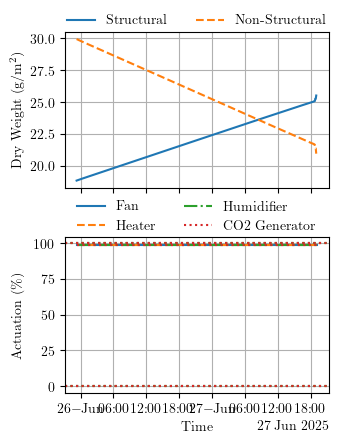

In [71]:
# [donotremove]
axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label=ylabel,
    u_label=ulabel,
    t_label=xlabel,
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/greenhouse_control-mpc_co2-N_{N}-steps_{sim_steps}.pdf"
)

# Control Scenario - no co2 care

In [ ]:
profit_costs = model.analyze_profit_and_costs(
    x0[-2:], U, climate["Electricity price [EUR/kWh]"].values[:sim_steps]
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-mpc_profit-N_{N}-steps_{sim_steps}.csv"
)

In [ ]:
profit_costs

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total'].sum():.2f} EUR! 🤑"
)

In [ ]:
# [donotremove]

axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label="Lettuce Dry Weight (g)",
    u_label="Actuation (\\%)",
    t_label="Time",
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/greenhouse_control-mpc_profit-N_{N}-steps_{sim_steps}.pdf"
)

## Linear MPC

In [53]:
from do_mpc.model import linearize

# === Model ===================================================================
model = GreenHouseModel(gh_model, climate_vars=climate.columns)
# Find feasible initial state
x0 = x_init.copy()
u0 = np.array([0.0] * len(gh_model.active_actuators))
tvp0 = tuple(climate.values[0])
x0 = model.init_states(x0, u0, tvp0)

linmodel = linearize(model, x0, u0, np.insert(climate.iloc[0].values, 0, 0))
linmodel.lettuce_price = model.lettuce_price
linmodel.gh = model.gh
linmodel.dt = model.dt

# === Control =================================================================
mpc = EconomicMPC(
    linmodel,
    climate,
    N,
    u_min=u_min,
    u_max=u_max,
)

# === Simulator ===============================================================
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)  # [1/dt]

mpc.x0 = x0
mpc.u0 = np.array([0.0] * model.n_u)
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

# Run the MPC simulation
U = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
X = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if step + N == len(climate):
            break

    with suppress_stdout():
        u0 = mpc.make_step(x0)
        U.iloc[step] = u0[:, 0]
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            raise ValueError("x0 contains NaN values.")
        X.iloc[step] = x0[:, 0]

    linmodel = linearize(
        model, x0, u0, np.insert(climate.iloc[step].values, 0, step)
    )
    linmodel.lettuce_price = model.lettuce_price
    linmodel.gh = model.gh
    linmodel.dt = model.dt
    mpc.model = linmodel

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
profit_costs = model.analyze_profit_and_costs(
    x0.flatten() - x_init, U, climate["energy_cost"].values[:sim_steps]
)
profit_costs.to_csv(
    f"{filepath}results/profit_costs-linmpc_co2-N_{N}-steps_{sim_steps}.csv"
)

In [ ]:
profit_costs

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs['Total']:.2f} EUR! 🤑"
)

In [ ]:
# [donotremove]

axs = plot_response(
    timestamps,
    X.iloc[:, -2:],
    U,
    u_min=u_min,
    u_max=u_max,
    y_legend=["Structural", "Non-Structural"],
    u_legend=[*gh_model.active_actuators.keys()],
    y_label=ylabel,
    u_label=ulabel,
    t_label=xlabel,
)

fig = axs[0].get_figure()
fig.savefig(
    f"{filepath}results/greenhouse_control-linmpc_co2-N_{N}-steps_{sim_steps}.pdf"
)